### Cambria Health - Data Scientist Application 
### Brian Cleary 

### Step 1 - Load data
Downloaded dataset as csv and loaded into Python Jupyter Notebook and confirmed the data matches description: 205 observations and 26 features loaded
 

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

# display for notebooks
%matplotlib inline
# Load Dataset 
data = pd.read_csv('Autos_imports_85_UTF.csv', sep=",", header=None,
                  names = ['symboling','normalized_losses', 'make', 
                          'fuel-type', 'aspiration', 'number_doors',
                          'body_style', 'drive_wheels', 'engine_location',
                          'wheel_base', 'length', 'width', 'height', 
                          'curb_weight', 'engine_type', 'num_of_cylinders',
                          'engine_size', 'fuel_system', 'bore', 'stroke', 
                          'compression_ratio', 'horsepower', 'peak_rpm',
                          'city_mpg', 'highway_mpg','price'])

print "Auto dataset has {} data points with {} variables each.".format(*data.shape)

Auto dataset has 205 data points with 26 variables each.


### Step 2 - Engineer feature for high,medium and low priced brands
Explored the make of cars by frequency count and noticed that several had very few observations.  I engineered a new categorical feature (Make2) that used three bins to separate car makers into a more generalized, categorical variable with three labels (high, medium and low priced label). I kept both features.  A visualization showed that the new feature seems appropriate for the task of generalizing brands by price. This ended up being one of the top four features in terms of importance. 


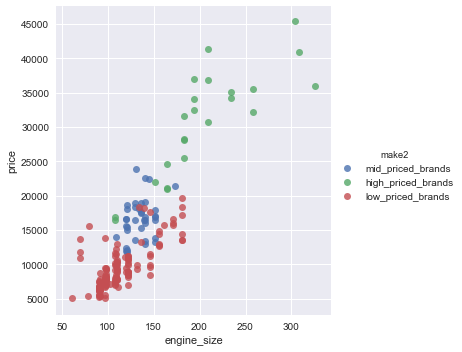

In [3]:
data.groupby(['make'])['price'].count() # didn't print for ease of reading 
grouped = data.groupby(['make'])['price'].median().reset_index()
grouped.sort_values('price', ascending = False) # didn't print for ease of reading 


high_priced_brands = ['jaguar', 'bmw', 'mercedes-benz',  'porsche' ]
for brand in high_priced_brands:
    data.loc[data.make == brand, 'make2'] = "high_priced_brands"
    
mid_priced_brands = ['volvo', 'audi','mercury',  'alfa-romero', 'peugot','saab']
for brand in mid_priced_brands:
    data.loc[data.make == brand, 'make2'] = "mid_priced_brands"
    
low_priced_brands = ['mazda', 'nissan', 'volkswagen', 'renault', 'toyota','mitsubishi', 'isuzu',
                    'subaru','honda','plymouth','dodge', 'chevrolet']
for brand in low_priced_brands:
    data.loc[data.make == brand, 'make2'] = "low_priced_brands"
    
print sns.lmplot("engine_size", "price", data, hue="make2", fit_reg=False)

### Step 3 - Display the correlations between numeric predictors
I used a heat map to display the correlations between numeric predictors. Since the goal is to predict the price of a car based on its attributes, I kept correlated features that were not quite as strong as they might help in predictions. The regression algorithms I will use later be robust enough to handle correlated features. This may lead to some interpretation issues later and will be discussed in the feature importance question. 


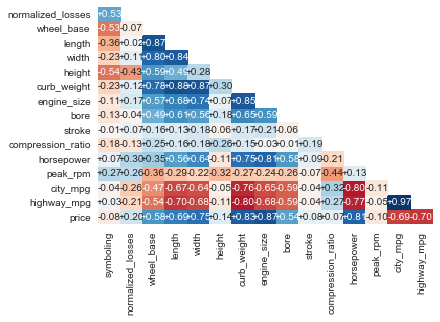

In [4]:
# Get correlations
corr = data.corr()

# remove first row and last column for a cleaner look
corr.drop(['symboling'], axis=0, inplace=True)
corr.drop(['price'], axis=1, inplace=True)

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# plot the heatmap
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', fmt='+.2f', cbar=False)


### Step 4 - Drop observations with missing price information
I dropped four missing values on the target variable (price) as imputing them could skew results. I subset data frame for predictors and response. I performed descriptive statistics on price.  


In [5]:
data2 = data.dropna(subset=['price'])
prices = data2['price']
features = data2.drop(['price'], axis = 1)

minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

print "\nDescriptive Statistics for Price in the Auto dataset:"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)


Descriptive Statistics for Price in the Auto dataset:
Minimum price: $5,118.00
Maximum price: $45,400.00
Mean price: $13,207.13
Median price $10,295.00
Standard deviation of prices: $7,927.27


### Step 5 - Statistics on Numeric Features | Check for missing values 
I ran descriptive statistics the numeric features to confirm no values were outside of the stated ranges in the documentation. If the counts did not match 201, then I knew there were missing values. 


In [6]:
features.describe()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
count,201.000000,164.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,197.000000,197.000000,201.000000,199.000000,199.000000,201.000000,201.000000
mean,0.840796,122.000000,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,3.330711,3.256904,10.164279,103.396985,5117.587940,25.179104,30.686567
std,1.254802,35.442168,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,0.270793,0.319256,4.004965,37.553843,480.521824,6.423220,6.815150
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000
25%,0.000000,94.000000,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000
75%,2.000000,150.000000,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000
max,3.000000,256.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000


### Step 6 - Impute Missing Values in numeric features 
For the numeric variables with missing values (normalized_losses, bore, stroke, horsepower, peak_rpm), I imputed the missing values with the mean. I chose to do this because with only 201 features, I did not want to discard any additional observations. 


In [7]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN',strategy='mean', axis=0)
missing_numeric = ['normalized_losses', 'bore','stroke','horsepower', 'peak_rpm']
imr = imr.fit(features[missing_numeric])
features_imputed = features.copy()
features_imputed[missing_numeric] = imr.transform(features[missing_numeric].values)

### Step 7 - Check Categorical Features | Recode 
I compared the documentation to each categorical label to check for erroneous, misspelled or missing labels. I changed the number of doors and number of cylinders features from categorical to numeric.  Since number of doors had two missing values, I changed them to the most common one, four doors.  


In [8]:
string_data = features_imputed.select_dtypes(include=["object"])
for col in string_data:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
    print("Unique values for {0}:\n{1}\n".format(col,features_imputed.groupby([col])[col].count()))
del string_data


features_imputed.loc[features_imputed.number_doors == "Unknown","number_doors"] = 4
features_imputed.loc[features_imputed.number_doors == "four","number_doors"] = 4
features_imputed.loc[features_imputed.number_doors == "two","number_doors"] = 2
features_imputed['number_doors'] = features_imputed['number_doors'].astype(int)

features_imputed.loc[features_imputed.num_of_cylinders == "two","num_of_cylinders"] = 2
features_imputed.loc[features_imputed.num_of_cylinders == "three","num_of_cylinders"] = 3
features_imputed.loc[features_imputed.num_of_cylinders == "four","num_of_cylinders"] = 4
features_imputed.loc[features_imputed.num_of_cylinders == "five","num_of_cylinders"] = 5
features_imputed.loc[features_imputed.num_of_cylinders == "six","num_of_cylinders"] = 6
features_imputed.loc[features_imputed.num_of_cylinders == "eight","num_of_cylinders"] = 8
features_imputed.loc[features_imputed.num_of_cylinders == "twelve","num_of_cylinders"] = 12
features_imputed['num_of_cylinders'] = features_imputed['num_of_cylinders'].astype(int)

Unique values for make:
['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo']

Unique values for make:
make
alfa-romero       3
audi              6
bmw               8
chevrolet         3
dodge             9
honda            13
isuzu             2
jaguar            3
mazda            17
mercedes-benz     8
mercury           1
mitsubishi       13
nissan           18
peugot           11
plymouth          7
porsche           4
renault           2
saab              6
subaru           12
toyota           32
volkswagen       12
volvo            11
Name: make, dtype: int64

Unique values for fuel-type:
['gas' 'diesel']

Unique values for fuel-type:
fuel-type
diesel     20
gas       181
Name: fuel-type, dtype: int64

Unique values for aspiration:
['std' 'turbo']

Unique values for aspiration:
aspiration
std      165
turbo     36
Na

### Step 8 - Price Distribution
I created a plot for the distribution of price. No cars are below 5,118 nor above 45,400 . The price distribution is right-skewed. Most observations are around 10,000 but there is a long right-tail for vehicles above 30,000. 


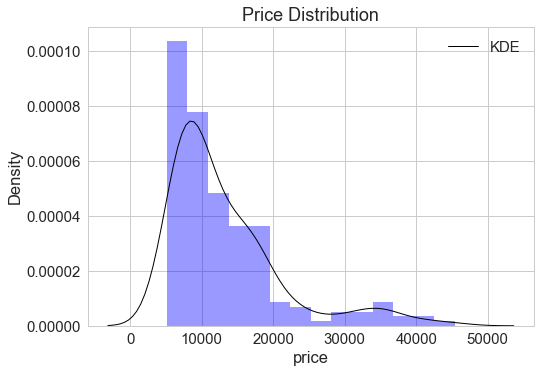

In [9]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(prices,
                 bins=None,
                 kde_kws={"color": "black", "lw": 1, "label": "KDE"},
                 color="blue")
    sns.plt.title("Price Distribution")
    sns.plt.ylabel("Density")
    #plt.xlim((-1, Age_Max_Train))

### Step 9 - Dummy Variables
I created Dummy Variables for the Categorical Features. This allows for a numeric representation of categorical features. I dropped the redundant label for each feature. 


 

In [10]:
def preprocess_Dummy_features(X):
    output = pd.DataFrame(index = X.index)
    for col, col_data in X.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        output = output.join(col_data)
    return output

Features_preprocessed = preprocess_Dummy_features(features_imputed)
Features_preprocessed = Features_preprocessed.drop(['make_alfa-romero', 'make2_low_priced_brands',
                                                     'fuel-type_diesel','aspiration_std',
                                                     'body_style_hardtop','drive_wheels_4wd',
                                                    'engine_location_rear','engine_type_dohc',
                                                    'fuel_system_1bbl'], axis=1) 


### Step 10 - Standardize Numeric Features 
I standardized the numeric features to bring them to the same scale. Standardization centers the features columns at mean zero and standard deviation of one and retains outlier information.



In [11]:
features_scale = ['symboling','wheel_base', 'normalized_losses', 
                  'length', 'width', 'height', 'curb_weight','city_mpg',
                  'engine_size', 'bore', 'stroke', 'compression_ratio', 
                  'horsepower', 'peak_rpm', 'highway_mpg']

std = StandardScaler()
Features_preprocessed[features_scale] = std.fit_transform(Features_preprocessed[features_scale])


### Step 11 - Split data into trains and testing sets
I split the data into a training set and testing set. The testing set will not be used in model building. It is held out until the very end to determine if grid search improved performance through hyper parameter tuning of the best model.


In [12]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Features_preprocessed, prices, test_size = 0.20, 
                                    random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


((160, 61), (160,))
((41, 61), (41,))


### Step 12 - Benchmark Performance | Model Selection 
I evaluated four supervised learning models (XGBoost Regressor, Linear Regressor with Lasso for regularization, Random Forest Regressor and KNN Regressor) with stock parameters to determine which model best matched the structure of the data. I used the R^2 and RMSE to quantify the model performance. R^2 is a relative measure of fit while RMSE is an absolute measure shown in dollars. 



In [13]:
def train_estimator(estimator, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    estimator.fit(X_train, y_train)
      
def predict_labels(estimator, features, target):
    ''' Makes predictions using a fit classifier based on R2 score. '''
    y_pred = estimator.predict(features)
    rmse = np.sqrt(mean_squared_error(target.values, y_pred))
    r2 = r2_score(target.values, y_pred)
    return [rmse,r2]
    # return r2_score(target.values, y_pred)

def train_predict(estimator, X_train, y_train, X_test, y_test):
    ''' Train and predict using a estimator based on R2 score. '''
    print "{} from a training set of size {}:".format(estimator.__class__.__name__, len(X_train))
    train_estimator(estimator, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "R^2 score for training set: {:.3f}".format(predict_labels(estimator, X_train, y_train)[1])
    print "R^2 score for test set: {:.3f}".format(predict_labels(estimator, X_test, y_test)[1])
    print "RMSE score for training set: ${:.0f}".format(predict_labels(estimator, X_train, y_train)[0])
    print "RMSE score for test set: ${:.0f}\n".format(predict_labels(estimator, X_test, y_test)[0])

regressors = ([XGBRegressor(seed=0),Lasso(
                random_state=43),KNeighborsRegressor(),
               RandomForestRegressor(random_state=43)])

X_train, X_test, y_train, y_test
for models in regressors:
    train_predict(models, X_train,y_train, X_test, y_test)

XGBRegressor from a training set of size 160:
R^2 score for training set: 0.994
R^2 score for test set: 0.917
RMSE score for training set: $625
RMSE score for test set: $2074

Lasso from a training set of size 160:
R^2 score for training set: 0.967
R^2 score for test set: 0.874
RMSE score for training set: $1477
RMSE score for test set: $2553

KNeighborsRegressor from a training set of size 160:
R^2 score for training set: 0.910
R^2 score for test set: 0.687
RMSE score for training set: $2424
RMSE score for test set: $4029

RandomForestRegressor from a training set of size 160:
R^2 score for training set: 0.989
R^2 score for test set: 0.888
RMSE score for training set: $839
RMSE score for test set: $2408



### Step 13 - Feature Importance
I measured feature importance with Random Forest. Once the model was randomly built with 5,000 trees, I found which feature where most important for prediction. This type of feature selection can be misleading for highly correlated features. For example, if highway mpg had been deleted, city mpg would have had more predictive power as both are strongly correlated. 


In [14]:
feat_labels_Train = Features_preprocessed.columns[:]
forest = RandomForestRegressor(n_estimators=5000, random_state=43,
                               n_jobs = -1)

forest.fit(Features_preprocessed, prices)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices  = indices[:10]

sum_x = np.sum(importances[indices])
print 'Total percent contribution of the top {} features is {:.2%}:'.format(10,(sum_x))

for f in range(len(indices)):
    print ("%2d %-*s %f" % (f,30,feat_labels_Train[indices[f]],importances[indices[f]]))

Total percent contribution of the top 10 features is 96.09%:
 0 engine_size                    0.578035
 1 curb_weight                    0.197407
 2 make2_high_priced_brands       0.080837
 3 highway_mpg                    0.044475
 4 horsepower                     0.017006
 5 width                          0.015935
 6 wheel_base                     0.007534
 7 city_mpg                       0.007174
 8 length                         0.006569
 9 compression_ratio              0.005880


### Step 14 - Grid search
I selected XGBoost and Lasso models for hyper parameter tuning based on the baseline scores. XGBoost had the highest R^2 value and lowest RMSE of the decision trees tested. Lasso is not a decision tree and if combined with XGBoost may create an ensemble model that generalizes better. I used Grid Search with cross-validation to tune hyper parameters for improve performance and to control overfitting. 


In [15]:
def fit_model(regressor, X, y, params):
    """Performs grid search on parameters specified below. """
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 43)
    scoring_fnc = make_scorer(r2_score)
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)
    grid = grid.fit(X, y)
    #print '{} Grid Search provided an R^2 score on Training set of {:.3f}'.format(regressor.__class__.__name__,grid.best_score_)
    return grid.best_estimator_

# XGBoost
regressor = XGBRegressor(seed=43)
params = {'max_depth':[3,4],
              'n_estimators':[350,450], 'colsample_bytree':[.50,.70,.90], 
              'learning_rate':[.05,.10], 'colsample_bylevel':[.80,.85,.95]}     
XGBoost_Grid = fit_model(regressor, X_train, y_train, params)
# Lasso
regressor = Lasso(random_state=3)
params = {'alpha': [1,5,10,15,20], 'tol' :[0.001,.01,.015,.02],
          'max_iter': [1000,1500,2000,5000]}
Lasso_Grid = fit_model(regressor, X_train, y_train, params)

### 15 - Predictions | Evaluation

The best model was an ensemble of the XGBoost Regressor and Lasso predictions. By averaging predictions, the ensemble model generalized better on the held-out test set. The ensemble had higher R^2 and lower RMSE then either model alone, 93.9% and 1,773 respectively. The R^2 value indicates that the model successfully explained approximately 94% of the variation in the price of a car on the test set. The RMSE on the test set show that the average prediction was off by 1,773.


In [16]:
XGB_ensemble = XGBoost_Grid.fit(X_train,y_train)
XGB_grid_pred = XGB_ensemble.predict(X_test)

Lasso_ensemble = Lasso_Grid.fit(X_train, y_train)
Lasso_grid_pred = Lasso_ensemble.predict(X_test)

ensemble_average = (XGB_grid_pred + Lasso_grid_pred)/2 

print "XGB R^2: {:.3f}".format(r2_score(y_test,XGB_grid_pred))
print "Lasso R^2: {:.3f}".format(r2_score(y_test,Lasso_grid_pred))
print "Ensemble R^2: {:.3f}\n".format(r2_score(y_test,ensemble_average,))

print "XGB RMSE: ${:.0f}".format(np.sqrt(mean_squared_error(y_test,XGB_grid_pred)))
print "Lasso RMSE: ${:.0f}".format(np.sqrt(mean_squared_error(y_test,Lasso_grid_pred)))
print "Ensemble RMSE: ${:.0f}".format(np.sqrt(mean_squared_error(y_test,ensemble_average)))

XGB R^2: 0.933
Lasso R^2: 0.896
Ensemble R^2: 0.939

XGB RMSE: $1870
Lasso RMSE: $2317
Ensemble RMSE: $1773


### 16 - Check for bias | heteroscedasticity

To determine if the model was biased, I tested for heteroscedasticity. I plotted the residuals (predicted price minus actual price) for the test set. The residual errors for the ensemble did not increase much as the price increased, showing the model was less biased.  



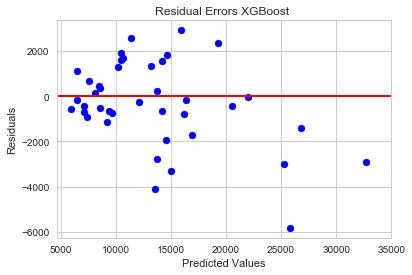

In [17]:
import matplotlib.pyplot as plt
plt.scatter(XGB_grid_pred, XGB_grid_pred- y_test, 
           c='blue', marker='o')
plt.title('Residual Errors XGBoost ')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
# plt.legend(loc = 'upper right')
plt.hlines(y=0, xmin=4600, xmax=35000, lw=2, color='red')
plt.xlim([4600,35000])
plt.show()

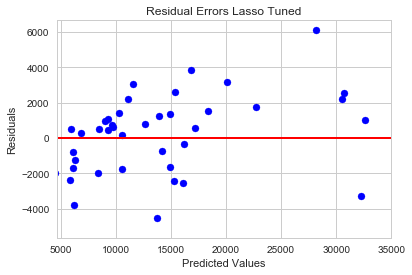

In [18]:
plt.scatter(Lasso_grid_pred, Lasso_grid_pred- y_test, 
           c='blue', marker='o')
plt.title('Residual Errors Lasso Tuned')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=4600, xmax=35000, lw=2, color='red')
plt.xlim([4600,35000])
plt.show()

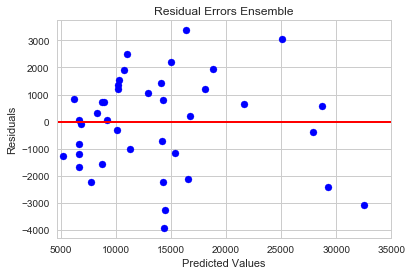

In [20]:
plt.scatter(ensemble_average,ensemble_average - y_test, 
           c='blue', marker='o')
plt.title('Residual Errors Ensemble')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=4600, xmax=35000, lw=2, color='red')
plt.xlim([4600,35000])
plt.show()